# Analyzing cell type resolved RNA expression of significantly increased expressed proteins in the sinus node using Martini et al. 2019 snRNAseq data set

Author: Konstantin Kahnert

Data from https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.119.041694

## Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Define required functions

In [2]:
def save_figure(fig, name, folder_output):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None

# Load data

In [3]:
folder_output = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Transcriptomics"

# load mean transcript numbers per cell type from Martini et al. paper
path_paper_S2 = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Transcriptomics\Mean_transcripts_Martini_et_al_2019.xlsx"
df_transcripts_paper = pd.read_excel(io=path_paper_S2, sheet_name="Avg. TAC, 4 weeks")

df_transcripts_paper.shape


(15169, 21)

In [4]:
# load singificantly differentially expressed proteins in HF in SN
path_signif_SN = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Proteome\Analysis\canonical\w_PIF\03_diff_expr_analysis\df_proteingroups_log_median subtraction_norm _empBayes_pvals_vp.xlsx"

df_signif_SN_up = pd.read_excel(io=path_signif_SN, sheet_name="signif. increased")
df_signif_SN_down = pd.read_excel(io=path_signif_SN, sheet_name="signif. decreased")

# Remove genes with 0 mean expression value in all cell types

In [5]:
df_transcripts_paper = df_transcripts_paper[df_transcripts_paper.sum(axis=1) != 0]
df_transcripts_paper.shape

(14230, 21)

In [6]:
df_transcripts_paper.head(5)

,gene,B cells,NK cells,B cells (activated),MHC-II+ resident macrophages,Osm+ M1-like,Phagocytic macrophages,CD8+ T cells (primed),Neutrophils,Osm+ M1-like.1,...,Dendritic cells,B cells (activated).1,NK cells (activated),CD4+ T-cells (acivated),Treg,CD8+ T cells (activated),Neutrophils.1,B cells (activated).2,T cell-like,Mast cell
0,Mrpl15,0.439901,0.529862,0.658294,0.599900,0.739260,0.644013,0.639767,0.428942,0.787198,...,0.817922,0.665974,0.565587,0.658895,0.813528,0.752609,0.069257,0.611694,0.645191,0.379979
1,Lypla1,0.480474,0.382550,0.489342,0.350654,0.523958,0.586566,0.424391,0.446822,0.591177,...,0.573413,0.403802,0.351913,0.516287,0.582684,0.446949,0.300797,0.399054,0.211641,0.110022
2,Tcea1,0.824518,0.653136,0.804256,0.712863,0.473465,0.535866,0.468538,0.489359,0.620406,...,0.881628,0.667348,0.712399,0.494306,0.760605,0.477088,0.026724,0.645758,0.266526,0.745569
3,Atp6v1h,0.697753,0.602175,0.739632,0.443326,0.580471,0.585193,0.338989,0.498355,0.603200,...,0.435037,0.431870,0.484818,0.586722,0.535511,0.441399,0.134136,0.682391,0.128394,0.628936
4,Rb1cc1,0.739039,1.019825,0.442311,0.454926,0.480746,0.557961,0.646594,0.540053,0.250948,...,0.343119,0.253532,0.405635,0.529538,0.520694,0.554114,1.135294,0.512461,0.378262,0.109459


## Z-normalize mean transcription data

In [7]:
# set gene names as index for transcript data
df_transcripts_paper = df_transcripts_paper.set_index("gene")
#df_transcripts = df_transcripts - df_transcripts.median()

# z-normalize count data
scaler = StandardScaler()
df_transcripts_paper_z = scaler.fit_transform(df_transcripts_paper.T)
df_transcripts_paper_z = pd.DataFrame(data=df_transcripts_paper_z, index=df_transcripts_paper.T.index, 
                                      columns=df_transcripts_paper.T.columns)

# get transcript counts for upregularted proteins
df_transcripts_paper_up_z = df_transcripts_paper_z.T[df_transcripts_paper_z.T.index.isin(df_signif_SN_up["Gene names"])].T

# get transcript counts for downregularted proteins
df_transcripts_paper_down_z = df_transcripts_paper_z.T[df_transcripts_paper_z.T.index.isin(df_signif_SN_down["Gene names"])].T



## Sort genes by highest expression for each cell type using 2 STDs as cutoff

In [8]:
# split data by expression >= 2.5 in any cell type and expression < 2.5 in all cell types
df_transcripts_up_z_high = df_transcripts_paper_up_z.T[(df_transcripts_paper_up_z.T >= 2).any(axis=1)]
df_transcripts_up_z_low = df_transcripts_paper_up_z.T[(df_transcripts_paper_up_z.T < 2).all(axis=1)]

df_transcripts_down_z_high = df_transcripts_paper_down_z.T[(df_transcripts_paper_down_z.T >= 2).any(axis=1)]
df_transcripts_down_z_low = df_transcripts_paper_down_z.T[(df_transcripts_paper_down_z.T < 2).all(axis=1)]

# sort by one column after another by decending values starting with the first and extract all genes 
# with values >= 2.5 for the sorted column
genes_sorted = []
for column in df_transcripts_up_z_high.columns:
    df_transcripts_up_z_high.sort_values(by=column, inplace=True, ascending=False)
    genes_high = list(df_transcripts_up_z_high[df_transcripts_up_z_high[column] >= 2].index)
    for i in genes_high:
        genes_sorted.append(i)
    df_transcripts_up_z_high.drop(genes_high)    

df_transcripts_up_z_high_sorted = df_transcripts_up_z_high.T[genes_sorted]

genes_sorted = []
for column in df_transcripts_down_z_high.columns:
    df_transcripts_down_z_high.sort_values(by=column, inplace=True, ascending=False)
    genes_high = list(df_transcripts_down_z_high[df_transcripts_down_z_high[column] >= 2].index)
    for i in genes_high:
        genes_sorted.append(i)
    df_transcripts_down_z_high.drop(genes_high)    

df_transcripts_down_z_high_sorted = df_transcripts_down_z_high.T[genes_sorted]




## Count genes with expression z score > 2 per cell type and visualize as bar plot

In [9]:
counts_all = (df_transcripts_paper_z.T > 2).sum()
counts_all.sort_values(ascending=False, inplace=True)
counts_all

T cell-like                     1337
NK cells                        1285
Mast cell                       1042
Neutrophils.1                    976
MHC-II+ resident macrophages     866
CD8+ T cells (primed)            833
Treg                             830
CD4+ T-cells (primed)            789
Osm+ M1-like                     779
B cells                          710
NK cells (activated)             625
Dendritic cells                  601
B cells (activated).2            574
Phagocytic macrophages           534
B cells (activated)              483
Osm+ M1-like.1                   476
B cells (activated).1            398
Neutrophils                      296
CD8+ T cells (activated)         281
CD4+ T-cells (acivated)          275
dtype: int64

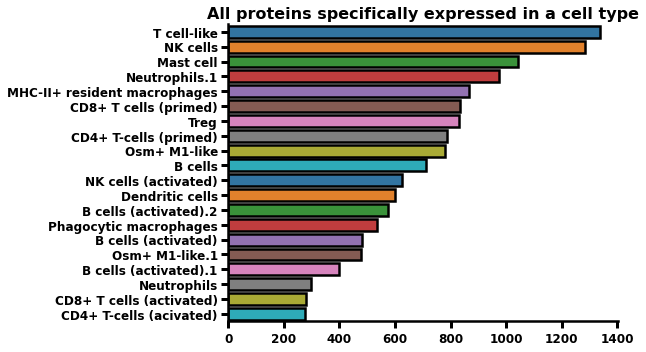

In [10]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts_all, y = counts_all.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("All proteins specifically expressed in a cell type", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()
# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_all_Martini_et_al"
save_figure(fig, name, folder_output)

## Plot z-scored RNA expression of singificantly upregulated proteins (based on proteome data) that have a z score > 2 

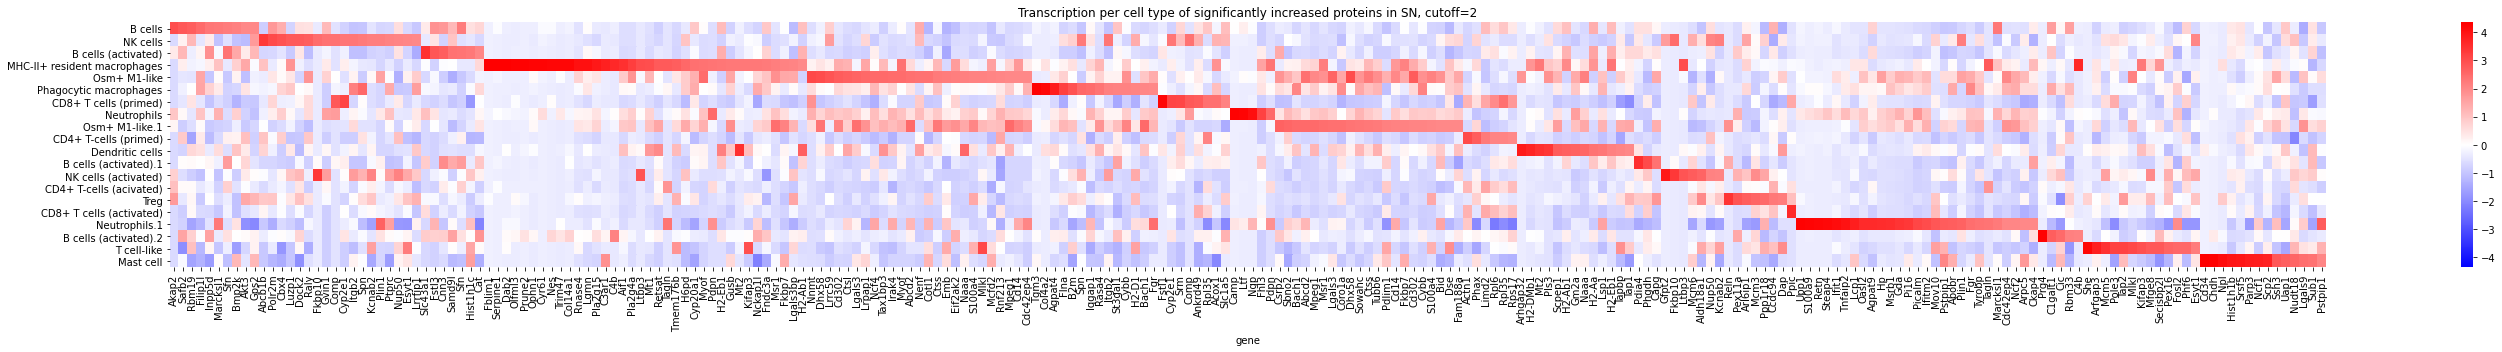

In [11]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.heatmap(df_transcripts_up_z_high_sorted, cmap="bwr", ax=ax,
            xticklabels=df_transcripts_up_z_high_sorted.columns, yticklabels=df_transcripts_up_z_high_sorted.index, 
            vmin=-df_transcripts_up_z_high_sorted.max().max(), vmax=df_transcripts_up_z_high_sorted.max().max())
plt.title("Transcription per cell type of significantly increased proteins in SN, cutoff=2")
plt.tight_layout()

# save figure
name = "transcripts_Martini_et_al_of_signif_proteins_SN_increased_heatmap_sorted_2cutoff"
save_figure(fig, name, folder_output)


## Count significantly upregulated proteins with RNA expression z score > 2 per cell type and visualize as bar plot

In [12]:
# Count singificantly upregulated proteins (based on proteome data) that have a z score > 2 for each cell type 
counts = (df_transcripts_up_z_high > 2).sum()
counts.sort_values(ascending=False, inplace=True)
counts

MHC-II+ resident macrophages    36
Neutrophils.1                   27
Osm+ M1-like                    25
Osm+ M1-like.1                  21
NK cells                        18
Mast cell                       14
Phagocytic macrophages          14
T cell-like                     13
Dendritic cells                 13
B cells                         10
CD8+ T cells (primed)            8
NK cells (activated)             7
Treg                             7
B cells (activated)              7
CD4+ T-cells (primed)            6
Neutrophils                      5
B cells (activated).2            5
B cells (activated).1            3
CD8+ T cells (activated)         1
CD4+ T-cells (acivated)          0
dtype: int64

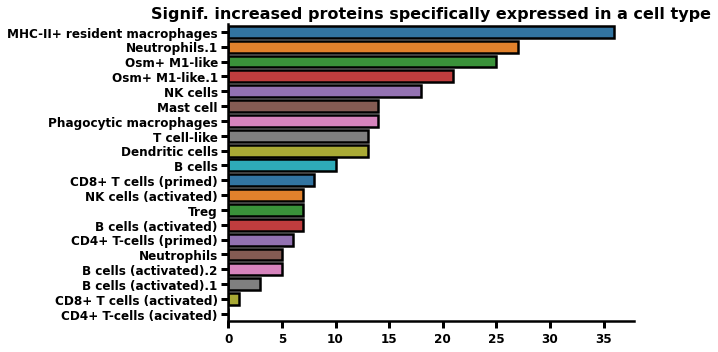

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts, y = counts.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("Signif. increased proteins specifically expressed in a cell type", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()

# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_incr_prot_Martini_et_al"
save_figure(fig, name, folder_output)

# Normalized by "specificity"  
  
i.e. divide by the number of specifically expressed genes per cell type based on all gene in whole snRNAseq data set

In [14]:
counts_norm = counts / counts_all * 100
counts_norm.sort_values(ascending=False, inplace=True)
counts_norm

Osm+ M1-like.1                  4.411765
MHC-II+ resident macrophages    4.157044
Osm+ M1-like                    3.209243
Neutrophils.1                   2.766393
Phagocytic macrophages          2.621723
Dendritic cells                 2.163062
Neutrophils                     1.689189
B cells (activated)             1.449275
B cells                         1.408451
NK cells                        1.400778
Mast cell                       1.343570
NK cells (activated)            1.120000
T cell-like                     0.972326
CD8+ T cells (primed)           0.960384
B cells (activated).2           0.871080
Treg                            0.843373
CD4+ T-cells (primed)           0.760456
B cells (activated).1           0.753769
CD8+ T cells (activated)        0.355872
CD4+ T-cells (acivated)         0.000000
dtype: float64

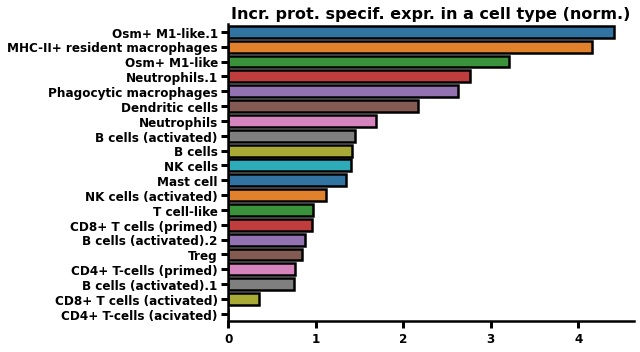

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts_norm, y = counts_norm.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("Incr. prot. specif. expr. in a cell type (norm.)", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()

# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_incr_prot_norm_Martini_et_al"
save_figure(fig, name, folder_output)